In [2]:
import json
import os
# Load JSON from file
with open("labels 3.json", "r") as f:
    data = json.load(f)

In [3]:
len(data)

11986

In [4]:
import pandas as pd

def extract_classification_fields(classification_answers):
    result = {}
    for classification in classification_answers.values():
        try:
            cls = classification['classifications'][0]
            name = cls['name']
            if isinstance(cls.get('answers'), list):
                result[name] = cls['answers'][0]['value']
            else:
                result[name] = cls['answers']
        except (KeyError, IndexError, TypeError):
            continue
    return result

rows = []

for entry in data:
    row = {'video_title': entry.get('data_title')}
    classification_answers = entry.get('classification_answers', {})
    row.update(extract_classification_fields(classification_answers))
    rows.append(row)

df = pd.DataFrame(rows)

In [5]:
df_nvidia = pd.read_csv('nvidia_delivery.csv')
df_nvidia['video_filename_only'] = df_nvidia['video_filename'].apply(os.path.basename)
merged_df = df.merge(df_nvidia, left_on='video_title', right_on='video_filename_only', how='left')
merged_df['event_type'] = merged_df['event_type'].str.lower().str.replace(' ', '_')
merged_df['video_type'] = merged_df['video_type'].str.lower().str.replace(' ', '_')
merged_df[['video_title','event_type','video_type']]
merged_df['event_type'] = merged_df['event_type'].apply(
    lambda x: x if x in ['near_collision', 'collision'] else 'normal'
)

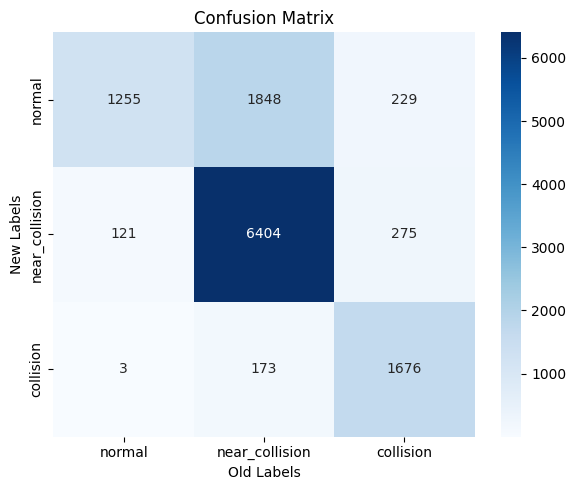

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Ensure clean string values
df_clean = merged_df.dropna(subset=['event_type', 'video_type']).copy()
df_clean['event_type'] = df_clean['event_type'].astype(str)
df_clean['video_type'] = df_clean['video_type'].astype(str)

# Define labels
labels = ["normal", "near_collision", "collision"]

# Compute confusion matrix
cm = confusion_matrix(df_clean['event_type'], df_clean['video_type'], labels=labels)

# Plot with custom axis labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Old Labels')
plt.ylabel('New Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


/tmp/ipykernel_4779/392007740.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered['event_time (minutes:seconds.milliseconds, e.g. 00:19.44)'].fillna('00:20.00', inplace=True)
/tmp/ipykernel_4779/392007740.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['event_time (minutes:seconds.milliseconds, e.g. 00:19.44)'].fill

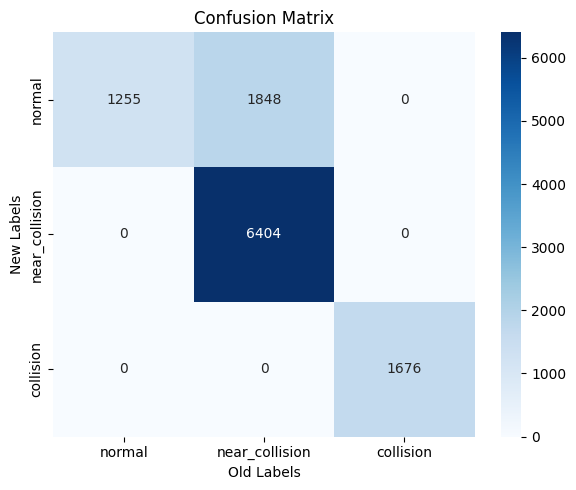

In [7]:
df_filtered = df_clean[
    (df_clean['event_type'] == df_clean['video_type']) | 
    ((df_clean['event_type'] == 'normal') & (df_clean['video_type'] == 'near_collision'))
]
df_filtered
df_filtered['event_time (minutes:seconds.milliseconds, e.g. 00:19.44)'].fillna('00:20.00', inplace=True)

cm = confusion_matrix(df_filtered['event_type'], df_filtered['video_type'], labels=labels)

# Plot with custom axis labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Old Labels')
plt.ylabel('New Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

/tmp/ipykernel_4779/1256233700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['video_path'] = df_filtered['video_filename']
/tmp/ipykernel_4779/1256233700.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['video_type_old'] = df_filtered['video_type']
/tmp/ipykernel_4779/1256233700.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

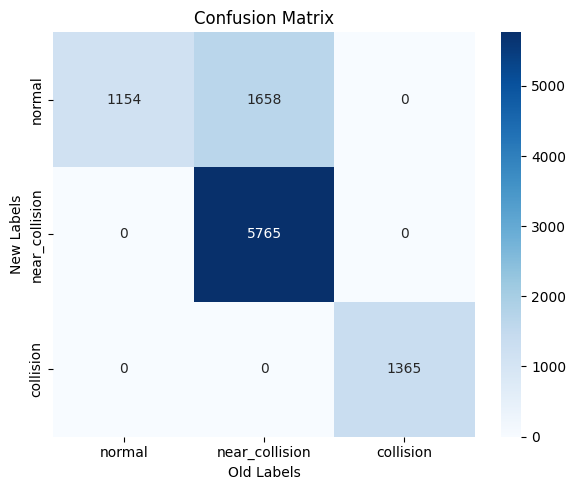

In [8]:
df_filtered['video_path'] = df_filtered['video_filename'] 
df_filtered['video_type_old'] = df_filtered['video_type']
df_filtered['video_type'] = df_filtered['event_type']

df_to_train = df_filtered[['id', 'video_title', 'video_path', 'video_type', 'event_time (minutes:seconds.milliseconds, e.g. 00:19.44)','video_type_old']]
import pandas as pd

def parse_event_time(t):
    try:
        minutes, rest = t.split(":")
        seconds = float(rest)
        return int(minutes) * 60 + seconds
    except:
        return None  # או np.nan

df_to_train["event_time_sec"] = df_to_train["event_time (minutes:seconds.milliseconds, e.g. 00:19.44)"].apply(parse_event_time)
df_to_train = df_to_train.loc[df_to_train['event_time_sec']<40].reset_index(drop=True).drop('event_time (minutes:seconds.milliseconds, e.g. 00:19.44)',axis=1)
df_to_train = df_to_train.loc[df_to_train['event_time_sec']>2.5].reset_index(drop=True)

cm = confusion_matrix(df_to_train['video_type'], df_to_train['video_type_old'], labels=labels)

# Plot with custom axis labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Old Labels')
plt.ylabel('New Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [9]:
# Filter rows where event_time_sec > 10
df_above_12_5 = df_to_train[df_to_train['event_time_sec'] > 12.5].copy()

# Create duplicated rows with updated event_time_sec and event_type
df_dup = df_above_12_5.copy()
df_dup['event_time_sec'] = df_dup['event_time_sec'] - 10
df_dup['video_type'] = 'normal'
df_dup['id'] = df_dup['id'].astype(str) + '_dup'

# Append to original DataFrame
df_augmented = pd.concat([df_to_train, df_dup], ignore_index=True).reset_index(drop=True)

df_augmented['video_type'].value_counts()

video_type
normal            12704
near_collision     5765
collision          1365
Name: count, dtype: int64

In [10]:
import pandas as pd
import numpy as np

# Duplicate rows for 'collision' with random time shift, within bounds
df_collision = df_augmented[df_augmented['video_type'] == 'collision']
augmented_rows = []

for i in range(3):  # three duplications
    df_aug = df_collision.copy()
    shift = np.random.uniform(-2, 2, size=len(df_aug))  # random shift [-2, 2]
    df_aug['event_time_sec'] += shift

    # Keep only rows within [2.5, 37.5]
    df_aug = df_aug[(df_aug['event_time_sec'] >= 2.5) & (df_aug['event_time_sec'] <= 37.5)]
    
    df_aug['id'] = df_aug['id'].astype(str) + f'_aug{i+1}'
    augmented_rows.append(df_aug)

# Append to original DataFrame
df_augmented = pd.concat([df_augmented] + augmented_rows, ignore_index=True).reset_index(drop=True)

# Check distribution
df_augmented['video_type'].value_counts()

video_type
normal            12704
near_collision     5765
collision          5460
Name: count, dtype: int64

In [11]:
import numpy as np
df_augmented['original_time'] = df_augmented['event_time_sec']
df_augmented['event_time_sec'] += np.random.uniform(-1, 1, size=len(df_augmented))

In [12]:
from sklearn.model_selection import train_test_split

# First split: train vs temp (val+test)
df_train, df_temp = train_test_split(df_augmented, test_size=0.10, random_state=42, shuffle=True)

# Second split: val vs test
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, shuffle=True)

# Assign split column
df_train['split'] = 'train'
df_val['split'] = 'val'
df_test['split'] = 'test'

# Concatenate all
df_augmented_split = pd.concat([df_train, df_val, df_test], ignore_index=True).reset_index(drop=True)

# Optional: check the distribution
df_augmented_split['split'].value_counts()

split
train    21536
test      1197
val       1196
Name: count, dtype: int64

In [13]:
df_normal = df_augmented_split[df_augmented_split['video_type'] == 'normal']
df_near_collision = df_augmented_split[df_augmented_split['video_type'] == 'near_collision']
df_collision = df_augmented_split[df_augmented_split['video_type'] == 'collision']

df_normal_sampled = df_normal.sample(n=len(df_near_collision), random_state=42)

df_balanced = pd.concat([df_normal_sampled, df_near_collision, df_collision]).reset_index(drop=True)

In [14]:
df_balanced.groupby("split")["video_type"].value_counts()

split  video_type    
test   collision          299
       normal             298
       near_collision     282
train  near_collision    5217
       normal            5205
       collision         4878
val    collision          283
       near_collision     266
       normal             262
Name: count, dtype: int64

In [15]:
df_balanced['video_type'] = df_balanced['video_type'].str.replace('_', ' ').str.title()

In [16]:
df_balanced['video_type'].value_counts()

video_type
Normal            5765
Near Collision    5765
Collision         5460
Name: count, dtype: int64

In [17]:
df_balanced.to_csv('df_encord_v3.csv',index=False)